# Code Implementation
This file contains the main pipeline for the project.

Additional helper functions and modules can be found under `src/`

**NOTE:**\
As our project is computationally intensive, using both CPU multithreading, GPU training and terabytes of data\
this notebook uses a subset of data. Thus, results may not completely align with results in the report.

Projected **run time is ~25 min**, although you may reduce it further (see 2nd cell), albeit with even less representative results

## Setup environment (if not done)
**Using uv (recommended)**:
```bash
uv venv --python ">=3.11"
source .venv/bin/activate
# or .venv\Scripts\activate for Windows
uv sync
```

**Using conda**:
```bash
conda create --name stcad-project python=">=3.11"
conda activate stcad-project
pip install -r requirements.txt
```

See [README](README.md) for more.

In [1]:
# Shared imports
import os
import pickle
import shutil
import joblib
import time
import numpy as np
import torch # To assist with data structures and training
import warnings
import matplotlib.pyplot as plt # For plotting
import seaborn as sns # For plotting
from tqdm.auto import tqdm
from datetime import date, timedelta
warnings.filterwarnings("ignore", message=".*pin_memory.*")

data_dir = "data/ais/"

In [29]:
# We recommend the following configuration to get somewhat reasonable results
# although you may adjust according to your hardware and likings.

# Projected run time: ~25 minutes
NOTEBOOK_CONFIG = {
    # Data is downloaded directly from the source. 3 days of data is 9GB raw.
    # You may reduce this to 2 days, although reducing further is not recommended.
    'data_date_min': date(2024, 5, 1),
    'data_date_max': date(2024, 5, 3), # To reduce change to: date(2024, 5, 2)
    
    # You may want to use a subset of the downloaded data for faster experimentation.
    # Set subset_data to a int (min 1000) to reduce run time.
    # This is the most effective way to reduce time requirements.
    'subset_data': False, # To reduce change to: 1000
    
    # If you don't have CUDA or MPS (Mac), we recommend setting this to False.
    # This will load the pretrained model without further training, and you will
    # not be able to produce the RCR matrix.
    'gpu_tasks': True, # To reduce change to: False
}

# FOR MINIMAL RUN TIME (results may be less representative) UNCOMMENT BELOW:
## Projected run time: ~7 minutes
#NOTEBOOK_CONFIG={'data_date_min': date(2024, 5, 1),'data_date_max': date(2024, 5, 2),
#                 'subset_data': 1000,'gpu_tasks': False}

## Download the data
The data used in this project is maritime data from automatic identification systems (AIS) obtained obtained from the [Danish Maritime Authority](http://aisdata.ais.dk/). The data is available as a csv file for each day and contains a row for each AIS message with columns such as **Timestamp**, **MMSI**, **Latitude**, **Longitude**, and more. MMSI stands for Maritime Mobile Service Identity and is a unique identifier for a vessel.

For this notebook we use a subset of the data by using data only for 3 days: `2024-05-01`, `2024-05-02`, `2024-05-03`

In [ ]:
import requests
import zipfile
import io

def download_ais_data(from_date: date, to_date: date, destination_path: str):
    """Downloads and unzips AIS data for a given date range."""
    
    if not os.path.exists(destination_path):
        os.makedirs(destination_path)
        
    print(f"Starting AIS data download from {from_date} to {to_date} into {destination_path}")

    base_url = "http://aisdata.ais.dk/"
    current_date = from_date
    
    errors = []
    successes = 0
    while current_date <= to_date:
        year = current_date.strftime("%Y")
        month = current_date.strftime("%m")
        day = current_date.strftime("%d")
        
        file_name = f"aisdk-{year}-{month}-{day}.zip" # Construct the file name and URL
        file_url = f"{base_url}{year}/{file_name}"
        
        print(f"Downloading: {file_url}")
        
        try:
            response = requests.get(file_url, stream=True)
            if response.status_code == 200:
                with io.BytesIO(response.content) as zip_buffer:
                    with zipfile.ZipFile(zip_buffer, 'r') as zip_ref:
                        zip_ref.extractall(destination_path)
                        unzipped_files = zip_ref.namelist()
                        assert len(unzipped_files) == 1, "Expected exactly one file in the zip archive."
                        successes += 1
                        
            elif response.status_code == 404:
                print(f"Data not found for {current_date} (404 Error). Skipping.")
                errors.append((current_date, "404 Not Found"))
            else:
                print(f"Failed to download {file_name}. Status code: {response.status_code}")
                errors.append((current_date, f"HTTP {response.status_code}"))
                
        except requests.exceptions.RequestException as e:
            print(f"An error occurred during download for {current_date}: {e}")
            errors.append((current_date, str(e)))
        except zipfile.BadZipFile:
            print(f"Downloaded file for {current_date} is not a valid zip file.")
            errors.append((current_date, "Bad Zip File"))
        except AssertionError as ae:
            print(f"Assertion error for {current_date}: {ae}")
            errors.append((current_date, str(ae)))
        
        current_date += timedelta(days=1)

    if len(errors) == 0:
        print("\nAll files downloaded successfully.")
    else:
        print(f"\nDownload succeeded for {successes}/{(successes + len(errors))} days.")
        print(f"Errors encountered for the following dates:")
        for err_date, err_msg in errors:
            print(f" - {err_date}: {err_msg}")
    print("End of download process.")
    
download_ais_data(NOTEBOOK_CONFIG['data_date_min'], NOTEBOOK_CONFIG['data_date_max'], data_dir)

## Data preprocessing using MapReduce
Uncompressed, the data for a single day takes up around 3GB of memory and we wish to process 3 months worth of data leading to an infeasible amount of data to keep in memory at one time. However, since the data is time series data and vessel voyages often spans across days, in order to properly preprocess the data we can't process the files in isolation. Secondly, we wish to speed up the wall clock time of preprocessing by efficiently utilizing parallel processing on multiple CPU's running on DTU's High Performance Computing (HPC) cluster. This is where MapReduce comes in.

### Split
We first converts each CSV file individually to dictionaries of arrays grouped by MMSI. The grouped dictionaries are saved as pickle files in a temporary directory. This is the split part of MapReduce.

In [3]:
import polars as pl
from collections import defaultdict
from src.preprocessing.preprocessing import LON_MIN, LON_MAX, LAT_MIN, LAT_MAX, SPEED_MAX as SOG_MAX
from src.preprocessing.csv2pkl import SHIP_TYPE_MAP, NAV_STT_MAP

# Define column indices
LAT, LON, SOG, COG, HEADING, ROT, NAV_STT, TIMESTAMP, MMSI, SHIPTYPE  = list(range(10))

def csv2pkl(input_dir="data/files/",
            output_dir="data/pickle_files"):
    """ Converts raw AIS CSV files to dictionaries grouped by MMSI and saves them as pickle files."""
    
    global LON_MIN, LON_MAX, LAT_MIN, LAT_MAX, SOG_MAX, SHIP_TYPE_MAP, NAV_STT_MAP
      
    l_csv_filename = [filename for filename in os.listdir(input_dir) if filename.endswith('.csv')]
    print(f"Found {len(l_csv_filename)} CSV files in {input_dir}.")
    
    os.makedirs(output_dir, exist_ok=True)
    
    results = {file_name: {"total_messages": 0, "filtered_messages": 0} for file_name in l_csv_filename}

    messages_processed = 0
    unique_vessels = set()
    for csv_filename in tqdm(l_csv_filename, desc=f'Reading csvs'):
        try:
            t_date_str = '-'.join(csv_filename.split('.')[0].split('-')[1:4])
            t_min = time.mktime(time.strptime(t_date_str + ' 00:00:00', "%Y-%m-%d %H:%M:%S"))
            t_max = time.mktime(time.strptime(t_date_str + ' 23:59:59', "%Y-%m-%d %H:%M:%S"))
            
            # Lazy load data using Polars
            lf = pl.scan_csv(os.path.join(input_dir, csv_filename),
                            schema_overrides={
                                "# Timestamp": pl.Utf8,
                                "MMSI": pl.Int64,
                                "Latitude": pl.Float64,
                                "Longitude": pl.Float64,
                                "Navigational status": pl.Utf8,
                                "ROT": pl.Float64,
                                "SOG": pl.Float64,
                                "COG": pl.Float64,
                                "Heading": pl.Int64,
                                "Ship type": pl.Utf8
                            })
            total_messages = lf.select(pl.len()).collect()[0,0]
            messages_processed += total_messages
            results[csv_filename]["total_messages"] = total_messages

            lf = (
                lf.with_columns(
                    pl.col("# Timestamp").str.to_datetime("%d/%m/%Y %H:%M:%S").dt.epoch("s").alias("Timestamp"), # Convert to UNIX timestamp
                    pl.col("Navigational status").replace_strict(NAV_STT_MAP, default=15) # Map navigational status to integers
                ).filter(
                    (pl.col("Latitude") >= LAT_MIN) & (pl.col("Latitude") <= LAT_MAX) &
                    (pl.col("Longitude") >= LON_MIN) & (pl.col("Longitude") <= LON_MAX) &
                    (pl.col("SOG") >= 0) & (pl.col("SOG") <= SOG_MAX) &
                    (pl.col("COG") >= 0) & (pl.col("COG") <= 360) &
                    (pl.col("Timestamp") >= t_min) & (pl.col("Timestamp") <= t_max)
                ).select( # Select only the 9 columns needed for the track + ship type
                    pl.col("Latitude"),
                    pl.col("Longitude"),
                    pl.col("SOG"),
                    pl.col("COG"),
                    pl.col("Heading"),
                    pl.col("ROT"),
                    pl.col("Navigational status"),
                    pl.col("Timestamp"),
                    pl.col("MMSI"),
                    pl.col("Ship type")
                )
            )
                    
            ### Vessel Type Mapping
            vessel_type_dir = os.path.join(output_dir, "vessel_types")
            os.makedirs(vessel_type_dir, exist_ok=True)
            vt_df = (
                lf.with_columns(
                    pl.col("Ship type").replace_strict(SHIP_TYPE_MAP, default=0)
                )
                .filter(pl.col("Ship type") != 0) # "Undefined"
                .group_by("MMSI")
                .agg(
                    pl.col("Ship type").mode().first().alias("VesselType")  # If multiple use the most frequent type
                )
                .collect()
            )
            
            unique_vessels.update(vt_df["MMSI"].to_list())
            
            # Save vessel types mapping
            VesselTypes = {row[0]: row[1] for row in vt_df.iter_rows()}
            vt_output_filename = csv_filename.replace('csv', 'pkl')
            with open(os.path.join(vessel_type_dir, vt_output_filename), "wb") as f:
                pickle.dump(VesselTypes, f)
                
            df = lf.drop("Ship type").collect() # Ship type column no longer needed
            results[csv_filename]["filtered_messages"] = df.height
            
            # Build tracks
            Vs_list = defaultdict(list)
            for row_tuple in tqdm(df.iter_rows(named=False), total=len(df), desc="Building track lists...", leave=False):
                mmsi = row_tuple[MMSI] 
                Vs_list[mmsi].append(row_tuple)
            
            Vs = {} # Final dictionary
            for mmsi, track_list in tqdm(Vs_list.items(), desc="Sorting and converting to NumPy...", leave=False):
                track_list.sort(key=lambda x: x[TIMESTAMP])
                Vs[mmsi] = np.array(track_list, dtype=np.float64)
            
            output_filename = csv_filename.replace('csv', 'pkl') 
            output_path = os.path.join(output_dir, output_filename)
            joblib.dump(Vs, output_path, compress=3)
    
        except Exception as e:
            print(f"Error processing file {csv_filename}: {e}")
        
    print("Conversion completed.")
    
    total_messages = sum(info["total_messages"] for info in results.values())
    total_filtered = sum(info["filtered_messages"] for info in results.values())
    print(f"Total messages processed: {total_messages}")
    print(f"Total messages after filtering: {total_filtered}")
    print(f"Total unique vessels: {len(unique_vessels)}")
    
csv2pkl(input_dir=data_dir, output_dir=f"{data_dir}/pickle_files/")

Found 3 CSV files in data/ais/.


Reading csvs:   0%|          | 0/3 [00:00<?, ?it/s]

Building track lists...:   0%|          | 0/15464605 [00:00<?, ?it/s]

Sorting and converting to NumPy...:   0%|          | 0/3963 [00:00<?, ?it/s]

Building track lists...:   0%|          | 0/16040042 [00:00<?, ?it/s]

Sorting and converting to NumPy...:   0%|          | 0/3562 [00:00<?, ?it/s]

Building track lists...:   0%|          | 0/15343098 [00:00<?, ?it/s]

Sorting and converting to NumPy...:   0%|          | 0/3891 [00:00<?, ?it/s]

Conversion completed.
Total messages processed: 60839630
Total messages after filtering: 46847745
Total unique vessels: 5022


### Mapping and shuffling
Now that the full dataset has been chunked (split) we map each item (trajectory) based on MMSI to a MMSI directory ready for preprocessing (reduction).

The resulting temporary directory has the structure:\
```
data/
└── temp_dir/
    ├── 123456789/                      # MMSI (unique vessel identifier)
    │   ├── chunk_0001.pkl              # Segment(s) from input_dir
    │   ├── chunk_0002.pkl
    │
    ├── 987654321/
    │   ├── chunk_0001.pkl
    │
    └── ...                             # One folder per MMSI
```

In [4]:
def map_and_shuffle(input_dir: str, temp_dir: str):
    """ Goes through all input files and re-sorts them by MMSI into a temporary directory. """
    
    input_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith(".pkl")] # Input files from chunking step
    
    print(f"Starting map and shuffle phase on {len(input_files)} files...")

    for file_path in tqdm(input_files, desc="Map and Shuffle"):
        data_dict = joblib.load(file_path)
            
        for mmsi, track_segment in data_dict.items():
            
            # Create a directory for this specific MMSI
            mmsi_dir = os.path.join(temp_dir, str(mmsi))
            os.makedirs(mmsi_dir, exist_ok=True)
            
            # Save this segment into the MMSI's folder
            # We name it after the original file to avoid collisions
            segment_filename = os.path.basename(file_path)
            output_path = os.path.join(mmsi_dir, segment_filename)
            
            joblib.dump(track_segment, output_path, compress=3)
    
    print("Map and shuffle phase completed.")

map_and_shuffle(input_dir=f"{data_dir}/pickle_files/", temp_dir=f"{data_dir}/temp_dir/")

Starting map and shuffle phase on 3 files...


Map and Shuffle:   0%|          | 0/3 [00:00<?, ?it/s]

Map and shuffle phase completed.


### Reduce (in parallel)
In the final step of the MapReduce algorithm, the reduction step, we apply preprocessing of the vessel trajectories. As we consider vessels' trajectories as independent from each other, and we have split and shuffled the trajectories by MMSI in the previous step, we are able to perform this step in parallel. 

The preprocessing includes identifying a vessels "voyages". We define a voyage as a contiguous sequence of AIS messages from the same vessel (possible across days), where the time interval between any two consecutive messages does not exceed two hours, and the vessel is actively moving (i.e., not moored or at anchor). See [D. Nguyen, R. Fablet](https://arxiv.org/pdf/2109.03958) for the full preprocessing rules implemented.

The folder structure for the finally preprocessed files will look like:
```
processed/
├── 123456789_0_processed.pkl            # Processed trajectory for MMSI 123456789 (segment 0)
├── 123456789_1_processed.pkl            # (if multiple processed trajectories exist for same MMSI)
├── 987654321_0_processed.pkl
├── 987654321_1_processed.pkl
└── ...
```
where each pickle file constitutes one sample.

In [ ]:
from multiprocessing import Pool, cpu_count
from collections import defaultdict
# Multiprocessing requires functions to be importable from a module
# The process_single_mmsi defined below is identical to the one imported here
from src.preprocessing.map_reduce import process_single_mmsi as _process_single_mmsi
from src.preprocessing.preprocessing import preprocess_mmsi_track # Preprocessing rules

def process_single_mmsi(mmsi_info):
    """ Process a single MMSI's track segments. """
    
    mmsi, mmsi_dir_path, final_dir = mmsi_info
    results = {}
    
    # Load all segments for this MMSI
    all_segments = []
    segment_files = [f for f in os.listdir(mmsi_dir_path) if f.endswith(".pkl") and not f.startswith("vessel_types_")]
    segment_files.sort() # Ensure chronological order
    if not segment_files:
        return {"error": f"No segment files found for MMSI {mmsi}",
                "error_code": 0}
    for seg_file in segment_files:
            segment_path = os.path.join(mmsi_dir_path, seg_file)
            track_segment = joblib.load(segment_path)
            all_segments.append(track_segment)
    
    results['num_segments'] = len(all_segments)
    
    try: # Merge into one track
        full_track = np.concatenate(all_segments, axis=0)
    except ValueError as e:
        return {"error": f"Error concatenating segments for MMSI {mmsi}: {str(e)}",
                "error_code": 1}

    try: # Run processing for single MMSI's track
        processed_data, preprocessing_results = preprocess_mmsi_track(full_track)
        results.update(preprocessing_results)
    except Exception as e:
        return {"error": f"Error processing track for MMSI {mmsi}: {str(e)}",
                "error_code": 2}
    
    if processed_data: # Save final result
        for k, traj in processed_data.items(): # Constitues a sample
            final_output_path = os.path.join(final_dir, f"{mmsi}_{k}_processed.pkl")
            data_item = {'mmsi': mmsi, 'traj': traj}
            joblib.dump(data_item, final_output_path, compress=3)
            
    return results
    
def reduce(final_dir: str, temp_dir: str, n_workers: int = None, chunk_size: int = 10):
    """ Preprocess vessel trajectories by MMSI in parallel."""
    
    os.makedirs(final_dir, exist_ok=True)
    mmsi_folders = os.listdir(temp_dir)
    
    # Prepare list of (mmsi, path, output_dir) tuples for parallel processing
    mmsi_tasks = []
    for mmsi in mmsi_folders:
        mmsi_dir_path = os.path.join(temp_dir, mmsi)
        if os.path.isdir(mmsi_dir_path):
            mmsi_tasks.append((mmsi, mmsi_dir_path, final_dir))
            
    if NOTEBOOK_CONFIG['subset_data'] is not False:
        assert isinstance(NOTEBOOK_CONFIG['subset_data'], int), "subset_data must be an integer."
        # Shuffle mmsi
        np.random.seed(42)
        np.random.shuffle(mmsi_tasks)
        subset_size = min(NOTEBOOK_CONFIG['subset_data'], len(mmsi_tasks))
        mmsi_tasks = mmsi_tasks[:subset_size]
        
    print(f"Starting reduce phase on {len(mmsi_tasks)} MMSI folders")
    
    results = defaultdict(int) # To count preprocessing statistics
    
    # Process in parallel using imap_unordered to avoid accumulating results in memory
    t0 = time.time()
    logging_interval = 100
    with Pool(processes=n_workers, maxtasksperchild=min(1,1000//chunk_size)) as pool:
        for i, result in enumerate(pool.imap_unordered(_process_single_mmsi, mmsi_tasks, chunksize=chunk_size), 1):
            if "error" in result:
                print(result["error"])
                results[f"error_code_{result['error_code']}"] += 1
            else:
                for key, value in result.items():
                    results[key] += value
            if i % logging_interval == 0:
                elapsed = time.time() - t0
                errors = sum([results[f"error_code_{code}"] for code in range(3)])
                print(f"Processed {i}/{len(mmsi_tasks)} MMSIs. Avg wall time per MMSI: {elapsed / float(i):.4f}s. Errors so far: {errors}.")
                t0 = time.time()
    
    for key, value in results.items():
        print(f"{key}: {value}")

n_workers = cpu_count() - 1
print(f"Using {n_workers} workers for reduce phase.")
reduce(final_dir=f"{data_dir}/processed/", temp_dir=f"{data_dir}/temp_dir/", n_workers=n_workers, chunk_size=10)

### Combine vessel_types and cleanup temporary files

In [6]:
vessel_type_dir = f"{data_dir}/pickle_files/vessel_types/"
vessel_types_combined = dict()
vessel_type_files = [f for f in os.listdir(vessel_type_dir) if f.endswith(".pkl")]
for vt_file in vessel_type_files:
    vt_path = os.path.join(vessel_type_dir, vt_file)
    with open(vt_path, "rb") as f:
        vt_mapping = pickle.load(f)
        vessel_types_combined.update(vt_mapping) # In case of conflicts, later files overwrite earlier ones
    os.remove(vt_path)
combined_vt_path = os.path.join(f"{data_dir}/processed/", "vessel_types.pkl")
with open(combined_vt_path, "wb") as f:
    pickle.dump(vessel_types_combined, f)

# Cleanup temporary directories
for temp_dir in [f"{data_dir}/temp_dir/", f"{data_dir}/pickle_files/"]:
    shutil.rmtree(temp_dir)
    
print("Cleanup completed.")

Cleanup completed.


In [7]:
from src.utils.datasets import AISDataset

# We use a custom built AISDataset that for a simple retrieves
# (sequence, seqlen, mmsi, time_start)
processed_dir = os.path.join(data_dir, "processed/")
ds = AISDataset(data_dir=processed_dir)
with open(os.path.join(processed_dir, "vessel_types.pkl"), "rb") as f:
    vessel_types_mapping = pickle.load(f) # dict

## Encoding sequences as vectors using a BERT-style encoder
We wish to represent a trajectory in full as something we can cluster. Thus, we wish to encode a trajectory (a sequence of AIS messages) into a single vector. Recently a lot of progress has been made in NLP encoding of sentences with BERT ([Jacob Devlin, et al.](https://arxiv.org/pdf/1810.04805)) and RoBERTa ([Yinhan Liu, et al.](https://arxiv.org/pdf/1907.11692)) successfully generating a meaningful vector representation of a sequence of tokens via the prepended [CLS] token. Particularly, the RoBERTa paper showed that with sufficient training data and epochs the encoder was able to reliably learn the [CLS] token solely with masked token modelling (MTM) training. We take inspiration from this approach and train BERT-like encoder on our full training set.

Since AIS sequences can be regarded as being more closed domain than general sentences, and since our train set, while large, still only comprises 362,986 samples (~2.6GB) we implement a smaller less complex architecture. Specifically, we use:
- 4 transformer layers
- 4 attention heads per layer
- Hidden size: 256

in contrast to eg. BERT-base that uses 12 layers, 12 attention heads per layer and a hidden size of 768.

We train the model on an MTM task with a masking probability of 15%, and use a dropout of 0.1 for both the hidden states and attention probabilities in each transformer layer.

**Tokenization**: A regular BERT model uses discrete tokens spanning a fixed-length vocabulary. Since we are dealing with 4 continuous features discretizing these into bins would quickly lead to an infeasible vocabulary size. Instead we use a continuous tokenization projecting the 4 continuous features to the required 256 dimension using a simple fully connected linear layer $$f: \mathbb{R}^4 \to \mathbb{R}^{256}.$$ To this we add positional encodings learned up to 512 positions, as transformers do not inherently encode token order.

For the purpose of this notebook we will load the already trained model and train it for a few epochs on the data subset for demonstration. The full training summary can be found in the [model README](models/pretrained_models/pretrained_bert-3026/README.md).

In [ ]:
from transformers import Trainer
from torchinfo import summary
from src.preprocessing.train_test_split import train_test_split_tracks
from src.sequence_modelling.configs import get_training_args
from src.sequence_modelling.models import AISBERT, AISDatasetBERT, DataCollator

# Instead of training from scratch, we load our model trained on 362,986 sequences
# and continue training for 5 epochs on the data subset for demonstration
model = AISBERT.from_pretrained('models/pretrained_models/pretrained_bert-3026')
print("Loaded pretrained model. Summary:\n", summary( # Print model summary
    model,
    input_size=(1, 512, 4),
    dtypes=[torch.float]
))

# Create train/eval split.
# We split based on MMSI, not time, to avoid data leakage.
train_test_split_tracks(data_dir=os.path.join(data_dir, 'processed'), val_size=0.2, copy=True)
train_dataset = AISDatasetBERT(os.path.join(data_dir, 'processed/train'), max_seq_len=512)
eval_dataset = AISDatasetBERT(os.path.join(data_dir, 'processed/val'), max_seq_len=512)
print(f"Train dataset size: {len(train_dataset)}, Eval dataset size: {len(eval_dataset)}")

# Handles masking
data_collator = DataCollator(mask_prob=0.15)

training_args = get_training_args(
    num_train_epochs=5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    eval_strategy="epoch", logging_steps=1,
    load_best_model_at_end=True
)
trainer = Trainer( # Trainer handles the entire training loop
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset
)

if NOTEBOOK_CONFIG['gpu_tasks']:
    print("Starting MTM training...")
    trainer.train()
    print("MTM training complete.")
    model = trainer.model
    
model.eval()
model.to('cpu')
pass

Loaded pretrained model. Summary:
Layer (type:depth-idx)                                  Output Shape              Param #
AISBERT                                                 [1, 512, 256]             65,792
├─AISEmbeddings: 1-1                                    [1, 512, 256]             --
│    └─Linear: 2-1                                      [1, 512, 256]             1,280
│    └─Embedding: 2-2                                   [1, 512, 256]             131,072
│    └─LayerNorm: 2-3                                   [1, 512, 256]             512
│    └─Dropout: 2-4                                     [1, 512, 256]             --
├─BertEncoder: 1-2                                      [1, 512, 256]             --
│    └─ModuleList: 2-5                                  --                        --
│    │    └─BertLayer: 3-1                              [1, 512, 256]             789,760
│    │    └─BertLayer: 3-2                              [1, 512, 256]             789,760
│  

Could not estimate the number of tokens of the input, floating-point operations will not be computed


Epoch,Training Loss,Validation Loss
1,0.007100,0.005362
2,0.006200,0.004991
3,0.006900,0.005063
4,0.006500,0.005070
5,0.006100,0.005119


MTM training complete.


### Use the trained model to calculate embeddings
Based on the processed dataset (of length $N$) we calculate $N$ embeddings using our trained model. We L2 normalize the embeddings, which makes the euclidian distance equal to the shifted Cosine similarity, which is normally used for embedding vectors. This will become useful later.

In [9]:
from torch.utils.data import DataLoader
from src.sequence_modelling.utils import l2_normalize_embeddings

def get_embeddings(data: AISDataset, model: AISBERT, l2_normalize: bool = True, batch_size: int = 64) -> tuple[np.ndarray, list]:
    
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    model.to(device)
    model.eval() # Unsure in eval mode
    
    data_collator = DataCollator(is_inference=True)
    dataloader = DataLoader(data, batch_size=32, shuffle=False, collate_fn=data_collator)

    num_samples = len(data)
    hidden_dim = model.config.hidden_size
    all_cls_vectors = np.zeros((num_samples, hidden_dim), dtype=np.float32) # Preallocate array
    
    all_mmsi = [] # To keep track of which vector belongs to which MMSI
    all_start_times = []
    start_idx = 0
    dataloader = tqdm(dataloader, total=len(dataloader), desc="Computing Embeddings")
    with torch.no_grad():
        for batch in dataloader:
            input_features = batch["input_features"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            mmsis = batch["mmsi"]
            start_times = batch["time_start"]
            
            # This is the output from the model
            outputs = model(
                input_features=input_features,
                attention_mask=attention_mask,
                labels=None
            )
            
            # To get the [CLS] token representation (classification of the whole sequence)
            # we extract the last hidden state and take the first token's embedding
            # Shape (batch_size, hidden_dim) = (batch_size, 256)
            last_hidden_state = outputs.hidden_states[-1]
            cls_token_vector = last_hidden_state[:, 0, :]
            
            batch_size = cls_token_vector.size(0)
            end_idx = start_idx + batch_size
            all_cls_vectors[start_idx:end_idx] = cls_token_vector.cpu().numpy()
            
            all_mmsi.extend(mmsis)
            all_start_times.extend(start_times)
            start_idx = end_idx

    if l2_normalize:
        all_cls_vectors = l2_normalize_embeddings(all_cls_vectors)
    return all_cls_vectors, all_mmsi, all_start_times

embeddings, mmsis, start_times = get_embeddings(ds, model, l2_normalize=True, batch_size=64)

Computing Embeddings:   0%|          | 0/126 [00:00<?, ?it/s]

To get an idea of how the embeddings lie in the embedding space we project the embeddings down to 2 dimensions. Unlike Principal Component Analysis (PCA) which calculates a linear projection Uniform Manifold Approximation and Projection (UMAP) are able to capture non-linear patterns in the high dimensional space. Thus, UMAP is often used for embeddings which often exhibits complex non-linear structures.

/Users/bertramhage/DTU/computational_tools/computational-tools-project/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


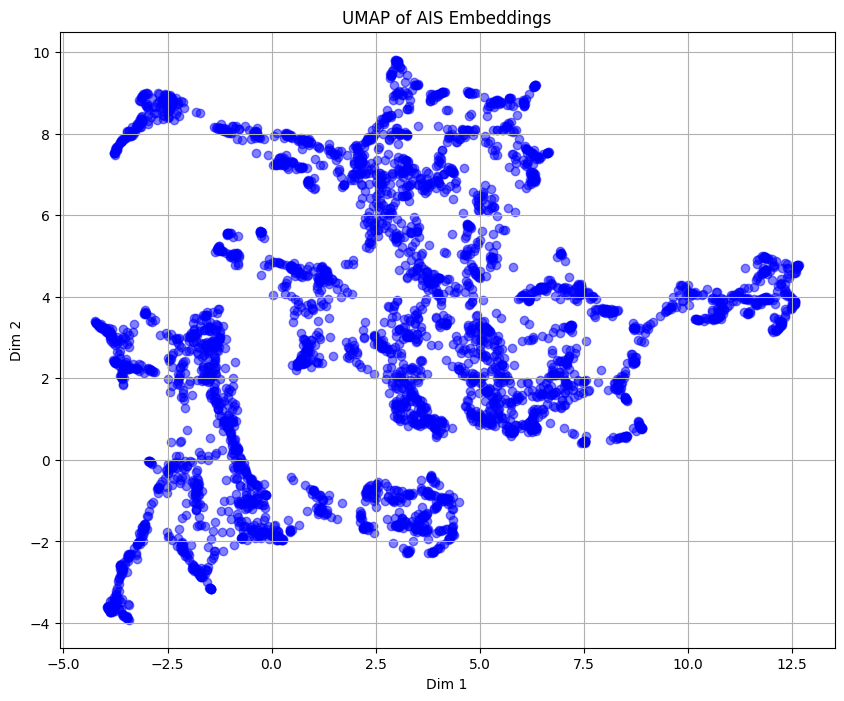

In [10]:
import umap
from src.utils.plot import plot_scatter

reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_umap = reducer.fit_transform(embeddings)
plot_scatter(embeddings_umap, title="UMAP of AIS Embeddings", xlab="Dim 1", ylab="Dim 2")

Clusters appears to be non-spherical suggesting single linkage for clustering to perform well, although there is a risk of chaining.

## Hierarchical clustering using the AISBERT-learned embeddings
This notebook implements the CURE algorithm to scale Agglomerative Clustering (AC) from cubic complexity to linear $O(n)$ time. We perform standard AC on a random sample (for report 1000 samples, for this notebook 150) to build the hierarchy. To ensure robustness, we discard samples that join the hierarchy late, preventing noise from distorting the cluster shapes. 

We try out linkage strategies WARD, single, and average.

The remaining points in the dataset are assigned to the nearest cluster representative as per the CURE algorithm. Using a defined assignment threshold, any point falling too far from a representative is distinctly labeled as an anomaly rather than being forced into a cluster.

To decrease the length of this notebook, some of the (trivial) methods are inherited from the `src/` package.

In [11]:
from src.clustering.utils import cluster_distance
from src.clustering.hierarchical import AgglomerativeClustering as AgglomerativeClustering_

# Define the AC class. We inherit from the module to reduce length.
class AgglomerativeClustering(AgglomerativeClustering_):
    """A custom implementation of Agglomerative Hierarchical Clustering."""
    def __init__(self, linkage='ward', pruning_fraction=0.05, pruning_min_size=1):
        super().__init__(linkage, pruning_fraction, pruning_min_size)
        self.noise_points_ = [] # To store indices of pruned points

    def fit(self, X):
        """ Fit the model and build the Linkage Matrix. """
        X = np.array(X)
        n_samples = X.shape[0]
        self.n_samples_ = n_samples
        
        # Initialize clusters
        current_clusters = {i: [i] for i in range(n_samples)}
        
        self.linkage_matrix_ = []
        
        # Create a id new clusters
        next_cluster_id = n_samples
        
        pruning_triggered = False

        # Loop until one cluster remains
        while len(current_clusters) > 1:
            if not pruning_triggered and len(current_clusters) <= n_samples * self.pruning_fraction:
                pruning_triggered = True
                
                ids_to_prune = []
                for cid, indices in current_clusters.items():
                    if len(indices) <= self.pruning_min_size:
                        ids_to_prune.append(cid)
                        self.noise_points_.extend(indices)
                
                for cid in ids_to_prune:
                    del current_clusters[cid]
            
            active_ids = list(current_clusters.keys())
            min_dist = np.inf
            best_pair = None

            # Find closest pair of active clusters
            for i in range(len(active_ids)):
                for j in range(i + 1, len(active_ids)):
                    id1 = active_ids[i]
                    id2 = active_ids[j]
                    
                    dist = cluster_distance(X, current_clusters[id1], current_clusters[id2], linkage=self.linkage)
                    
                    if dist < min_dist:
                        min_dist = dist
                        best_pair = (id1, id2)
                        
            c1, c2 = best_pair
            
            # Create new cluster
            new_indices = current_clusters[c1] + current_clusters[c2]
            
            # Store [c1, c2, distance, size]
            self.linkage_matrix_.append([float(c1), float(c2), float(min_dist), len(new_indices)])
            
            # Update clusters
            del current_clusters[c1]
            del current_clusters[c2]
            current_clusters[next_cluster_id] = new_indices
            
            next_cluster_id += 1

        self.linkage_matrix_ = np.array(self.linkage_matrix_)
        return self

    def get_labels(self, n_clusters):
        """ Replays the clustering history to return labels for a specific number of clusters. """
        if self.linkage_matrix_ is None:
            raise RuntimeError("Model must be fit before getting labels.")
            
        n_samples = self.n_samples_ - len(self.noise_points_)

        # Reconstruct state at desired number of clusters
        current_clusters = {i: [i] for i in range(self.n_samples_)}
        
        num_merges = n_samples - n_clusters
        for i in range(num_merges):
            row = self.linkage_matrix_[i]
            c1, c2 = int(row[0]), int(row[1])
            new_id = self.n_samples_ + i
            
            current_clusters[new_id] = current_clusters[c1] + current_clusters[c2]
            del current_clusters[c1]
            del current_clusters[c2]

        # Assign labels
        noise_set = set(self.noise_points_)
        labels = np.full(self.n_samples_, -1, dtype=int) # Initialize as noise
        valid_label_id = 0
        for cluster_id in sorted(current_clusters.keys()):
            indices = current_clusters[cluster_id]
            if indices[0] in noise_set:
                continue
            for sample_idx in indices:
                labels[sample_idx] = valid_label_id
            valid_label_id += 1
                
        return labels

In [12]:
from src.clustering.utils import euclidean_distance, davies_bouldin_index
from src.clustering.hierarchical import CURE as CURE_

# Similarly, we inherit from the module to reduce length.
class CURE(CURE_):
    """ CURE (Clustering Using REpresentatives) Implementation."""
    def __init__(self, sample_size, n_representatives, compression, linkage, assignment_threshold=None):
        super().__init__(sample_size, n_representatives, compression, linkage)
        self.assignment_threshold = assignment_threshold if assignment_threshold is not None else np.inf
        self.agg_ = None
        self.X_sample_ = None
        self.X_ = None # Store reference to full dataset
        
    def fit(self, X):
        """Samples the data and builds the hierarchical cluster tree on the sample. """
        self.X_ = np.array(X)
        n_samples = self.X_.shape[0]

        if n_samples <= self.sample_size:
            sample_indices = np.arange(n_samples)
            self.X_sample_ = self.X_
        else:
            np.random.seed(self.seed)
            sample_indices = np.random.choice(n_samples, self.sample_size, replace=False)
            self.X_sample_ = self.X_[sample_indices]

        self.agg_ = AgglomerativeClustering(linkage=self.linkage, pruning_fraction=self.pruning_fraction, pruning_min_size=self.pruning_min_size)
        self.agg_.fit(self.X_sample_)
        
        return self
    
    def _get_representatives(self, n_clusters, compression=None):
        """
        Internal helper to calculate representatives for a specific number of clusters.
        """
        if self.agg_ is None:
            raise RuntimeError("Model not fitted.")
        
        if compression is None:
            compression = self.compression

        sample_labels = self.agg_.get_labels(n_clusters)

        representatives = []
        for k in range(n_clusters):
            cluster_points = self.X_sample_[sample_labels == k]
            
            if len(cluster_points) == 0:
                representatives.append([])
                continue

            centroid = np.mean(cluster_points, axis=0)

            reps = []
            if len(cluster_points) <= self.n_representatives:
                 reps = [p for p in cluster_points]
            else:
                dists = [euclidean_distance(p, centroid) for p in cluster_points]
                first_idx = np.argmax(dists)
                reps.append(cluster_points[first_idx])
                
                for _ in range(self.n_representatives - 1):
                    max_min_dist = -1
                    best_candidate = None
                    
                    for p in cluster_points:
                        # Find min distance to any existing rep
                        min_dist_to_reps = min([euclidean_distance(p, r) for r in reps])
                        
                        if min_dist_to_reps > max_min_dist:
                            max_min_dist = min_dist_to_reps
                            best_candidate = p
                    
                    if best_candidate is not None:
                        reps.append(best_candidate)

            # Shrink towards centroid
            shrunk_reps = []
            for r in reps:
                new_pos = r + compression * (centroid - r)
                shrunk_reps.append(new_pos)
            
            representatives.append(shrunk_reps)
            
        return representatives
    
    def predict(self, X, n_clusters, assignment_threshold=None):
        """
        Assigns labels to new data points based on the fitted model and a specific number of clusters.
        """
        if self.agg_ is None:
            raise RuntimeError("Run fit() or load_pretrained() before predict()")
        
        if assignment_threshold is None:
            assignment_threshold = self.assignment_threshold
        
        X = np.array(X)
        n_samples = X.shape[0]
        labels = np.zeros(n_samples, dtype=int)
        
        representatives = self._get_representatives(n_clusters)

        for i in range(n_samples):
            point = X[i]
            min_dist = np.inf
            best_cluster = -1
            
            # Check distance to all representatives of all clusters
            for cluster_idx, reps in enumerate(representatives):
                if not reps:
                    continue
                for r in reps:
                    dist = euclidean_distance(point, r)
                    if dist < min_dist:
                        min_dist = dist
                        best_cluster = cluster_idx
            
            if min_dist > assignment_threshold:
                labels[i] = -1
            else:
                labels[i] = best_cluster
            
        return labels

Lets inspect the dendrograms for the three linkage strategies. Hyperparameters n_representatives, compression, and assignment_threshold are chosen based on a coarse initial grid search.

Fitting CURE models on embeddings...

CURE with Ward Linkage:


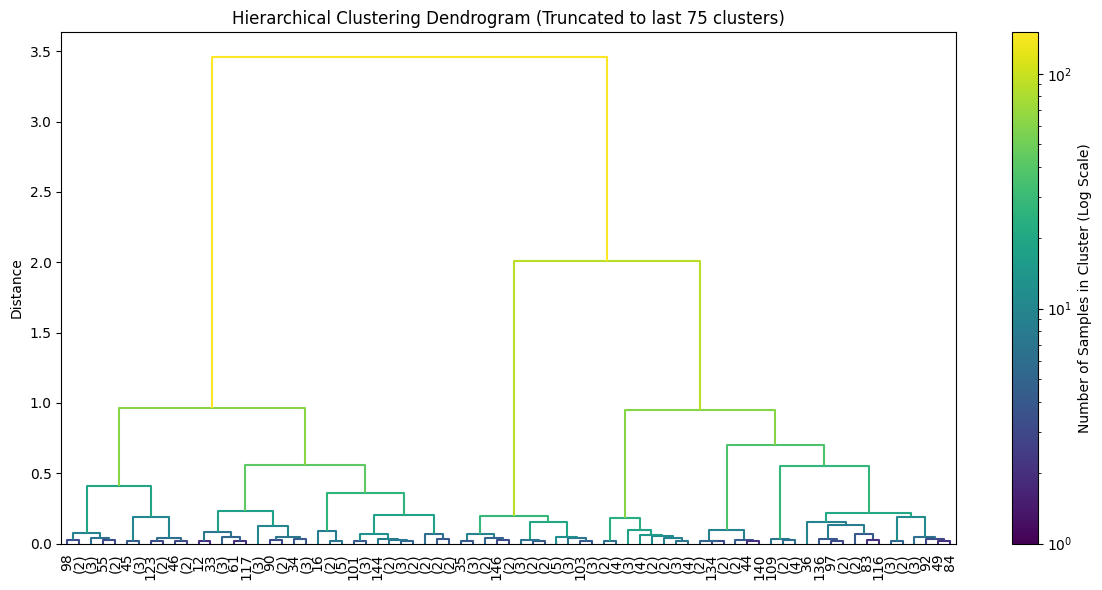


CURE with Average Linkage:


<Figure size 640x480 with 0 Axes>

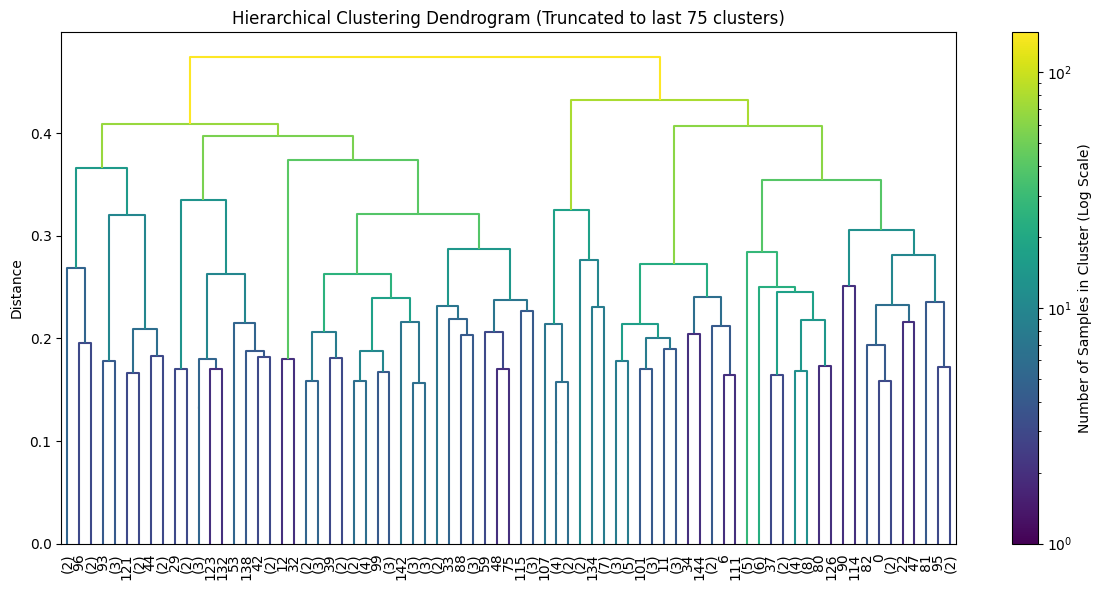


CURE with Single Linkage:


<Figure size 640x480 with 0 Axes>

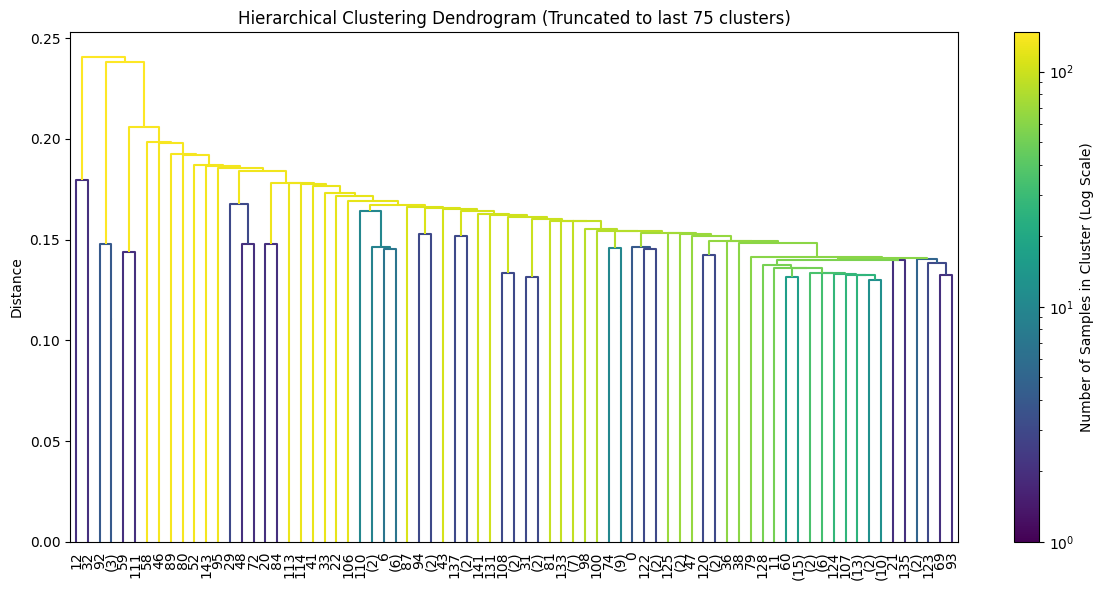

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [25]:
print("Fitting CURE models on embeddings...\n")
print("CURE with Ward Linkage:")
cure_model_ward = CURE(sample_size=150,
                       n_representatives=20,
                       compression=0.6,
                       linkage='ward',
                       assignment_threshold=0.24)
cure_model_ward.fit(embeddings)
cure_model_ward.plot_dendrogram(p=75, show_plot=True)

print("\nCURE with Average Linkage:")
cure_model_average = CURE(sample_size=150,
                          n_representatives=20,
                          compression=0.6,
                          linkage='average',
                          assignment_threshold=0.24)
cure_model_average.fit(embeddings)
cure_model_average.plot_dendrogram(p=75, show_plot=True)

print("\nCURE with Single Linkage:")
cure_model_single = CURE(sample_size=150,
                         n_representatives=20,
                         compression=0.6,
                         linkage='single',
                         assignment_threshold=0.24)
cure_model_single.fit(embeddings)
cure_model_single.plot_dendrogram(p=75, show_plot=True)

Results are clear: WARD provides a good looking dendrogram with stable cut points in the hierarchy while the dendrogram for average is crowded and unstable, and (like feared) single linkage shows clear signs of chaining, with a single cluster of large size absorbing all other points early.

We proceed with the WARD linkage. We will choose 5 clusters, offering a good balance between stability and interpretability. Now we'll predict the labels on the full dataset using CURE.

In [26]:
cure_model = cure_model_ward
labels_5 = cure_model.predict(embeddings, n_clusters=5)
dav_boild_idx_5 = davies_bouldin_index(embeddings, labels_5)
print(f"CURE with 5 clusters: Davies-Bouldin Index = {dav_boild_idx_5:.4f}")

CURE with 5 clusters: Davies-Bouldin Index = 2.8689


A Davies-Bouldin Index of 2.8689 is not in itself impressive. Although when clustering real-world, noisy data in high dimensions, it may be what we can expect.

## Evaluate clusters
Now it is time to have a look at the clusters, what characterize them, and if they appear usefull at all.

We start by plotting "characteristic" samples of each clusters, defined by the 20 closest samples in the AC sample set, closest to the cluster centroid.

In [27]:
# Pick 20 samples closest to centroids
cluster_centroids_5 = {}
for k in range(5):
    sample_labels = cure_model.agg_.get_labels(5)
    cluster_points = cure_model.X_sample_[sample_labels == k]
    centroid = np.mean(cluster_points, axis=0)
    cluster_centroids_5[k] = centroid
    
samples_5 = {}
for k, centroid in cluster_centroids_5.items():
    sample_labels = cure_model.agg_.get_labels(5)
    cluster_points = cure_model.X_sample_[sample_labels == k]
    distances = np.linalg.norm(cluster_points - centroid, axis=1)
    closest_indices = np.argsort(distances)[:20]
    for index in closest_indices:
        emb = cluster_points[index]
        distances = np.linalg.norm(embeddings - emb, axis=1)
        original_index = np.argmin(distances)
        assert distances[original_index] < 1e-6, "No exact match found for representative embedding."
        samples_5.setdefault(k, []).append(int(original_index))

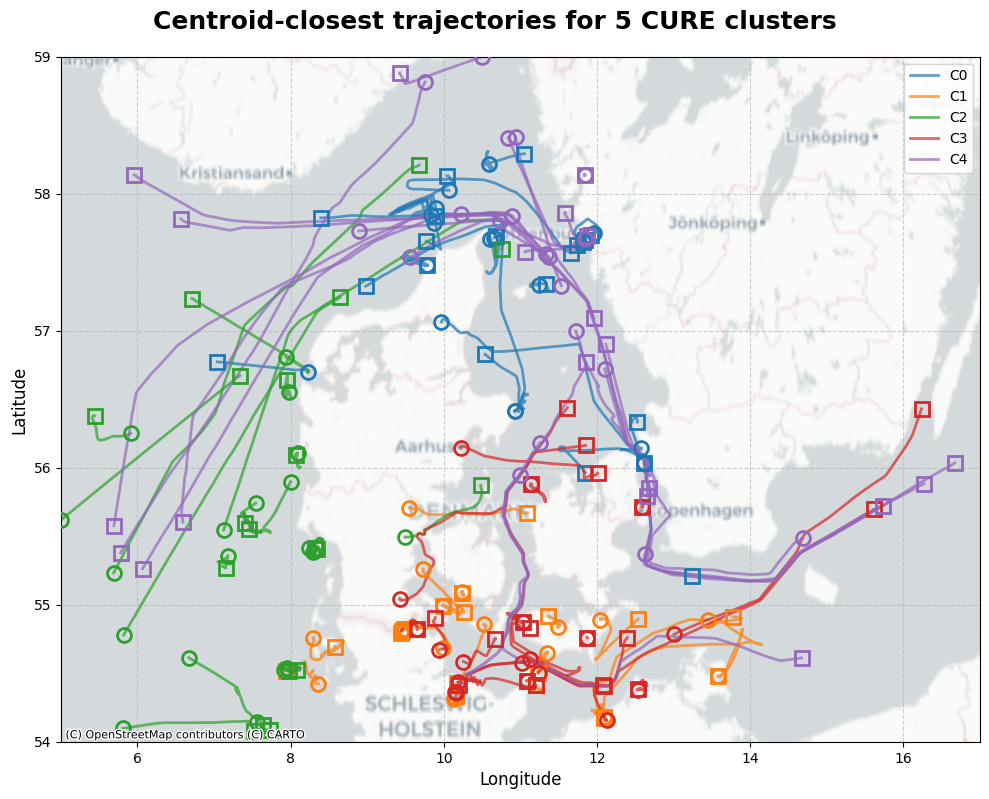

In [28]:
from src.utils.plot import plot_trajectories

tracks_to_plot = []
color_map = plt.get_cmap('tab10').colors
color_map = list(color_map)
for cluster_label, indeces in samples_5.items():
    for i in indeces:
        mmsi = mmsis[i]
        start_time = start_times[i]
        track, _,_,_ = ds.get_sample_by_mmsi_and_start_time(mmsi, start_time)
        color = color_map[cluster_label]
        tracks_to_plot.append({'track': track, 'color': color, 'label': f"C{cluster_label}"})
plot_trajectories(tracks_to_plot, show_plot=True, title="Centroid-closest trajectories for 5 CURE clusters")

We see some meaning in the clusters, with eg. cluster 1 being short trips around Funen and cluster 0 being trajectories north of the Jutland Peninsula.

To further characterise the clusters we create a "physical features" dataset for the samples. This has demographic features such as:
- Average longitude
- Average latitude
- Average, max and std for SOG
- Displacement
- COG std (high value means lots of turns)

In [17]:
# Build dataset of physical features
import pandas as pd
data = []
for i in range(len(ds)):
    row = ds.get_sample_features(i)
    row['vessel_type'] = vessel_types_mapping.get(int(mmsis[i]), 59)
    row['cluster_label_5'] = labels_5[i]
    data.append(row)
df = pd.DataFrame(data)
df.head()

,speed_avg,speed_max,speed_std,nav_status,duration,hour_start,month,lat_max,lat_min,lon_max,...,lat_mean,lon_mean,lat_median,lon_median,displacement,length,length_over_displacement,cog_std,vessel_type,cluster_label_5
0,16.475623,28.427475,7.562827,15,17100.0,9,5,56.270304,55.922199,15.754215,...,56.162889,15.433261,56.183688,15.400298,26338.453857,127487.758117,4.840366,80.851725,59,-1
1,11.090439,28.060403,8.301927,15,19800.0,9,5,56.275111,56.224395,15.859623,...,56.255207,15.442598,56.260426,15.279470,853.183860,160410.716868,188.014242,54.972437,59,-1
2,3.819286,5.779159,0.983106,15,31500.0,12,5,54.752058,54.400335,11.118478,...,54.547167,10.845506,54.541593,10.803188,48380.157693,54322.765629,1.122832,39.797759,37,1
3,3.567016,7.384697,3.156353,0,38700.0,2,5,54.374546,54.104405,10.176992,...,54.315789,9.882469,54.357697,9.981849,62804.157278,70806.637092,1.127420,45.295691,70,3
4,2.457528,9.200000,3.913422,5,78900.0,2,5,55.878862,55.233926,13.075877,...,55.764483,12.802345,55.864785,12.825974,71988.596743,100166.450825,1.391421,71.937795,70,0


In [18]:
continuous_features = ['speed_avg', 'speed_std', 'speed_max', 'duration', 'displacement', 'length_over_displacement', 'cog_std', 'lat_mean', 'lon_mean']
scores_df = (df[continuous_features] - df[continuous_features].mean()) / df[continuous_features].std()

feature_importances = {f: [] for f in continuous_features}
cluster_label_col = f'cluster_label_5'
scores_df_ = scores_df.copy()
scores_df_[cluster_label_col] = df[cluster_label_col]
scores_df_ = scores_df_[scores_df_[cluster_label_col] != -1]

cluster_profiles = scores_df_.groupby(cluster_label_col).mean()

# Calculate standard deviation across clusters for each feature
feature_importance = cluster_profiles.std().sort_values(ascending=False)
for f in continuous_features:
    feature_importances[f].append(feature_importance[f])
    
max_importance_per_feature = {f: max(importances) for f, importances in feature_importances.items()}
sorted_features = sorted(max_importance_per_feature.items(), key=lambda x: x[1], reverse=True)
print("Feature importances (max std dev across clusterings):")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")

Feature importances (max std dev across clusterings):
lat_mean: 0.7890
lon_mean: 0.7313
speed_avg: 0.4457
displacement: 0.4221
cog_std: 0.4039
speed_std: 0.2892
duration: 0.2141
speed_max: 0.1763
length_over_displacement: 0.1449


Most important features globally appear to be: average latitude, average longitude, average speed, displacement, and COG std. We proceed with these.

Now we want to see how these differ between the clusters. We define a Z-score:
$$
Z = \frac{\mu_{cluster,feature} - \mu_{global,feature}}{\sigma_{global,feature}}.
$$

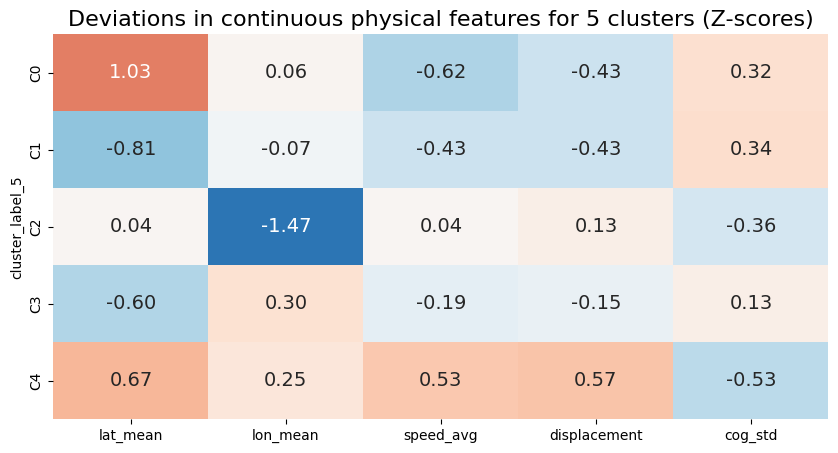

In [19]:
continuous_features = ['lat_mean', 'lon_mean', 'speed_avg', 'displacement', 'cog_std']
scores_df = (df[continuous_features] - df[continuous_features].mean()) / df[continuous_features].std()

cluster_label_col = f'cluster_label_5'
scores_df_ = scores_df.copy()
scores_df_[cluster_label_col] = df[cluster_label_col]
scores_df_ = scores_df_[scores_df_[cluster_label_col] != -1] # Don't include noise points

cluster_profiles = scores_df_.groupby(cluster_label_col).mean()

plt.figure(figsize=(10, 5))
sns.heatmap(
    cluster_profiles, 
    annot=True,
    cmap='RdBu_r',
    center=0,
    fmt='.2f',
    vmax=2,
    vmin=-2,
    yticklabels=[f'C{i}' for i in cluster_profiles.index],
    cbar=False,
    annot_kws={'fontsize': 14}
)
plt.title("Deviations in continuous physical features for 5 clusters (Z-scores)", fontsize=16)
plt.show()

Takeaways: Cluster 0 has high latitude (confirms hunch from trajectory plot) and low speed, while cluster 2 have low longitude.\
Cluster 1 has low latitude and low speed (in line with shorter trips too).

Let's see if vessel types differ between clusters.

Since vessel type is a categorical feature we define a similar $PMI$ score:
$$
PMI_{V=v} = \log_2\left(\frac{P(V=v|cluster)}{P(V=v)}\right),
$$
where $V$ represents the vessel type feature and $v$ denotes a specific category (e.g., Tanker).

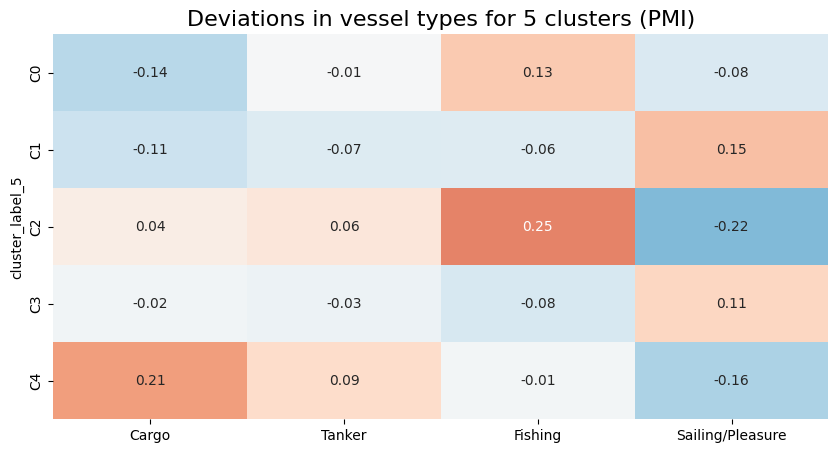

In [20]:
# Simplify vessel types to major categories
c, t, f, s = 'Cargo', 'Tanker', 'Fishing', 'Sailing/Pleasure'
vt_adapter = {
    70: c, 71: c, 72: c, 73: c, 74: c, 75: c, 76: c, 77: c, 78: c, # Cargo
    80: t, 81: t, 82: t, 83: t, 84: t, 85: t, 86: t, 87: t, 88: t, # Tanker
    30: f, # Fishing
    37: s, 36: s # Sailing / Pleasure
}
df['vessel_type_simple'] = df['vessel_type'].map(vt_adapter).fillna("Other")

dummies = pd.get_dummies(df['vessel_type_simple'], columns=['vessel_type_simple'])

cluster_label_col = f'cluster_label_5'
dummies[cluster_label_col] = df[cluster_label_col]
dummies = dummies[dummies[cluster_label_col] != -1] # Exclude noise points

global_means = dummies.drop(columns=[cluster_label_col]).mean()
cluster_means = dummies.groupby(cluster_label_col).mean()

pmi = cluster_means.sub(global_means, axis=1)

pmi = pmi.drop(columns=['Other'])
pmi = pmi[['Cargo', 'Tanker', 'Fishing', 'Sailing/Pleasure']]

plt.figure(figsize=(10, 5))
sns.heatmap(
    pmi,
    annot=True,
    cmap='RdBu_r',
    center=0,
    fmt='.2f',
    vmin=-0.5,
    vmax=0.5,
    cbar=False,
    yticklabels=[f'C{i}' for i in pmi.index],
)
plt.title("Deviations in vessel types for 5 clusters (PMI)", fontsize=16)
plt.show()

C1 is mainly sailing / pleasure (makes sense from short trips) and C0 is mainly fishing (makes sense for sailing north of Denmark to the North Sea). C4 is mainly Cargo, aligning with high speed and displacement from before.

## Evaluating anomaly detection

Since our CURE with AC approach includes an intrinsic noise detection we wish to evaluate this ability. The noise assignment includes two tweakable hyperparameters: number of clusters and assignment threshold. To get a sense of how these affect the noise detection results we calculate:
1. The percentage of noise observed given a certain number of clusters and assignment threshold
2. The average reconstruction error for the BERT model for the noise points compared to the cluster points. We denote this $RCR$:
$$
RCR = \frac{\mathbb{E}[\text{MSE}_{noise}]}{\mathbb{E}[\text{MSE}_{cluster}]},
$$
where $\mathbb{E}[\text{MSE}_{noise}]$ and $\mathbb{E}[\text{MSE}_{cluster}]$ denotes the average MSE for points labelled as noise and part of a cluster, respectively.

  0%|          | 0/6 [00:00<?, ?it/s]

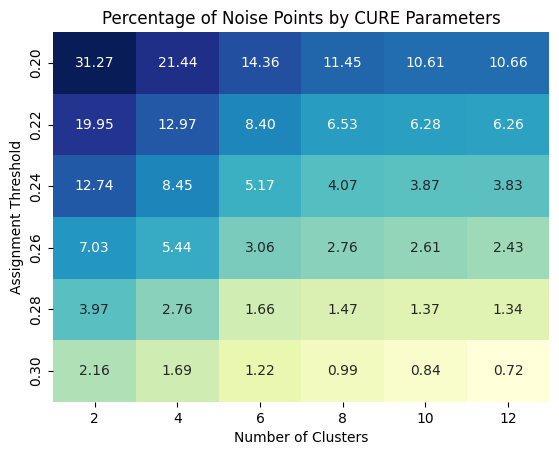

In [21]:
def get_pct_noise(model, X, n_clusters, assignment_threshold):
    labels = model.predict(X, n_clusters=n_clusters, assignment_threshold=assignment_threshold)
    pct_noise = np.sum(labels == -1) / len(labels) * 100
    return pct_noise

n_clusters_list = list(range(2, 13, 2))
assignment_thresholds = list(np.arange(0.2, 0.31, 0.02))
pct_noise_matrix = np.zeros((len(assignment_thresholds), len(n_clusters_list)))
for i, at in tqdm(enumerate(assignment_thresholds), total=len(assignment_thresholds)):
    for j, nc in enumerate(n_clusters_list):
        pct_noise = get_pct_noise(cure_model, embeddings, n_clusters=nc, assignment_threshold=at)
        pct_noise_matrix[i, j] = pct_noise
    
from matplotlib.colors import LogNorm
sns.heatmap(
    pct_noise_matrix,
    xticklabels=n_clusters_list,
    yticklabels=[f"{at:.2f}" for at in assignment_thresholds],
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    norm=LogNorm(),
    cbar=False,
)
plt.title("Percentage of Noise Points by CURE Parameters")
plt.xlabel("Number of Clusters")
plt.ylabel("Assignment Threshold")
plt.show()

Evaluating RCR with n_clusters=2
Evaluating RCR with n_clusters=4
Evaluating RCR with n_clusters=6
Evaluating RCR with n_clusters=8
Evaluating RCR with n_clusters=10
Evaluating RCR with n_clusters=12


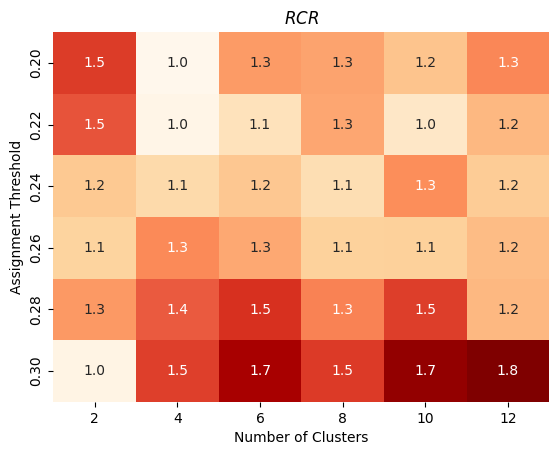

In [ ]:
from torch.utils.data import Subset

if NOTEBOOK_CONFIG['gpu_tasks']:

    if torch.cuda.is_available():
        device = 'cuda'
    elif torch.backends.mps.is_available():
        device = 'mps'
    else:
        device = 'cpu'
            
    model = AISBERT.from_pretrained('models/pretrained_models/pretrained_bert-3026')
    model.to(device)
    model.eval()

    full_dataset = AISDatasetBERT(os.path.join(data_dir, 'processed'), max_seq_len=512)

    def get_group_loss(model, dataset, indices, batch_size=64, device='cuda', truncate=False):
        """Computes the average MLM loss for a specific subset of indices."""
        
        if len(indices) == 0: return 0.0

        subset = Subset(dataset, indices)
        
        if truncate: # For faster testing, limit to first 5 batches
            subset = Subset(subset, list(range(min(batch_size*5, len(subset)))))
        
        collator = DataCollator(mask_prob=0.15, is_inference=False)
        loader = DataLoader(subset, batch_size=batch_size, collate_fn=collator, shuffle=False, num_workers=0, pin_memory=True)
        
        total_loss_sum = 0.0
        total_samples = 0
        with torch.inference_mode():
            for i, batch in enumerate(loader):
                input_features = batch['input_features'].to(device, non_blocking=True)
                attention_mask = batch['attention_mask'].to(device, non_blocking=True)
                labels = batch['labels'].to(device, non_blocking=True)
                
                outputs = model(
                    input_features=input_features, 
                    attention_mask=attention_mask, 
                    labels=labels
                )

                current_batch_size = input_features.size(0)
                total_loss_sum += outputs.loss.item() * current_batch_size
                total_samples += current_batch_size
                                
        return total_loss_sum / total_samples if total_samples > 0 else 0.0

    rcr_matrix = np.zeros((len(assignment_thresholds), len(n_clusters_list)))
    for j, n_cluster in enumerate(n_clusters_list):
        print(f"Evaluating RCR with n_clusters={n_cluster}")
        for i, threshold in enumerate(assignment_thresholds):
            labels = cure_model.predict(embeddings, n_clusters=n_cluster, assignment_threshold=threshold)
            noise_idxs = np.where(labels == -1)[0]
            cluster_idxs = np.where(labels != -1)[0]

            avg_noise_loss = get_group_loss(model, full_dataset, noise_idxs, 32, device, truncate=True)
            avg_cluster_loss = get_group_loss(model, full_dataset, cluster_idxs, 32, device, truncate=True)

            rcr = avg_noise_loss / (avg_cluster_loss + 1e-9) # safety epsilon
            rcr_matrix[i, j] = rcr

    sns.heatmap(
        rcr_matrix,
        xticklabels=n_clusters_list,
        yticklabels=[f"{at:.2f}" for at in assignment_thresholds],
        annot=True,
        fmt=".1f",
        cmap="OrRd",
        norm=LogNorm(),
        cbar=False,
    )
    plt.title(r"$RCR$")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Assignment Threshold")
    plt.show()

else:
    print("Skipping RCR computation as GPU tasks are disabled in the configuration.")

We see a negative correlation between noise percentage and $RCR$, with both cluster size and assignment threshold affecting noise percentage negatively and $RCR$ positively, which is in line with expectation. (Keep in mind, that since the sample size is much smaller than for the full analysis in the report, the results are not as clear here as in the report).

We proceed the analysis with 12 clusters and an assignment threshold of 0.22.

Now we wish to investigate what characterizes noise points using our previous scores Z-score and $PMI$:

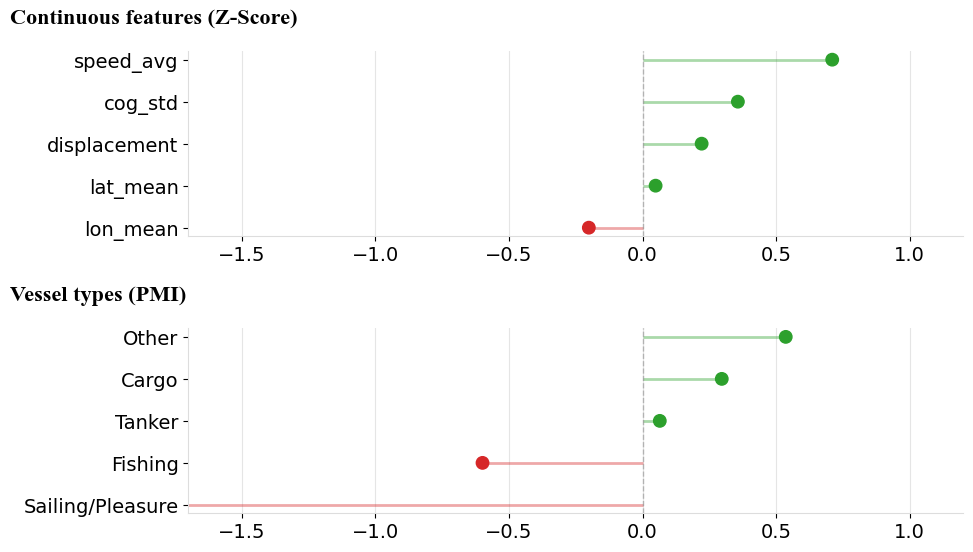

In [ ]:

from src.utils.plot import plot_lollipop

labels_noise = cure_model.predict(embeddings, n_clusters=12, assignment_threshold=0.22)
noise_mask = labels_noise == -1
df_noise = df[noise_mask]
df_clusters = df[~noise_mask]

cont_scores = {}
cat_scores = {}

continuous_features = ['lat_mean', 'lon_mean', 'speed_avg', 'cog_std', 'displacement']

for col in continuous_features:
    z_score = (df_noise[col].mean() - df_clusters[col].mean()) / df_clusters[col].std()
    cont_scores[col] = z_score
    
# Vessel types (categorical)
target_types = ['Cargo', 'Tanker', 'Fishing', 'Sailing/Pleasure', 'Other']

p_noise = df_noise['vessel_type_simple'].value_counts(normalize=True)
p_clusters = df_clusters['vessel_type_simple'].value_counts(normalize=True)

for v_type in target_types:
    p_n = p_noise.get(v_type, 1e-6)
    p_c = p_clusters.get(v_type, 1e-6)
    
    pmi_score = np.log2(p_n / p_c)
    cat_scores[v_type] = pmi_score
    
df_cont_plot = pd.DataFrame(list(cont_scores.items()), columns=['Feature', 'Score']).sort_values('Score')
df_cat_plot = pd.DataFrame(list(cat_scores.items()), columns=['Feature', 'Score']).sort_values('Score')

fig, (ax1, ax2) = plt.subplots(
    nrows=2, 
    ncols=1, 
    figsize=(10, 6), 
    sharex=False, 
    gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.5}
)

plot_lollipop(ax1, df_cont_plot, "Continuous features (Z-Score)")
plot_lollipop(ax2, df_cat_plot, "Vessel types (PMI)")
plt.show()

We see that noise points at this setting tend exhibit high speed and are situated at lower longitudes than cluster points. Additionally, noise trajectory are more likely than cluster points to be marked with label types other than Cargo, Fishing, Tanker, Sailing or Pleasure, with an especially low representation of Sailing/Pleasure vessels in noise trajectories, suggesting a high degree of cluster purity for recreational vessels.

## End of notebook